Resources:

https://www.tensorflow.org/hub/tutorials/movenet

https://www.kaggle.com/models/google/movenet/frameworks/tensorFlow2/variations/multipose-lightning

https://www.youtube.com/watch?v=KC7nJtBHBqg&ab_channel=NicholasRenotte

- single player variant
- get faster over time
- game over after a certain time or once a certain score is hit, display "game over" and show score
- restart button
- ...


In [1]:
%matplotlib inline
# Import TF and TF Hub libraries.
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import matplotlib.pyplot as plt

In [ ]:
# Check for GPU usage
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

In [2]:
# Download the model from TF Hub.
model = hub.load("https://www.kaggle.com/models/google/movenet/frameworks/TensorFlow2/variations/multipose-lightning/versions/1")
movenet = model.signatures['serving_default']

In [3]:
# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to an RGB color
EDGES_DICT = {
    (0, 1): (255,0,0),
    (0, 2): (0,0,255),
    (1, 3): (255,0,0),
    (2, 4): (0,0,255),
    (0, 5): (255,0,0),
    (0, 6): (0,0,255),
    (5, 7): (255,0,0),
    (7, 9): (255,0,0),
    (6, 8): (0,0,255),
    (8, 10): (0,0,255),
    (5, 6): (0,255,0),
    (5, 11): (255,0,0),
    (6, 12): (0,0,255),
    (11, 12): (0,255,0),
    (11, 13): (255,0,0),
    (13, 15): (255,0,0),
    (12, 14): (0,0,255),
    (14, 16): (0,0,255)
}

In [ ]:
HANDS_ON_HEAD_POSE_JOINTS = ['left_wrist', 'right_wrist', 'nose']

# Funktion zur Überprüfung der "Hands on Head"-Pose für einen Spieler
def is_hands_on_head_pose(keypoints_with_scores, player_index=0, confidence_threshold=0.3):
    pose_confidence = 0.0
    for joint_name in HANDS_ON_HEAD_POSE_JOINTS:
        joint_index = KEYPOINT_DICT[joint_name]
        pose_confidence += keypoints_with_scores[player_index, joint_index, 2]

    average_confidence = pose_confidence / len(HANDS_ON_HEAD_POSE_JOINTS)
    return average_confidence > confidence_threshold


In [4]:
def draw_keypoints(frame, keypoints_with_scores, confidence_threshold):
    img = frame.copy()
    height, width, _ = img.shape

    for person in keypoints_with_scores:
        for kp in person:
            if kp[2] > confidence_threshold:
                cv2.circle(img, (int(kp[1]*width),int(kp[0]*height)), radius=10, color=(255,255,255), thickness=-1)
    return img

In [7]:
def draw_edges(frame, keypoints_with_scores, confidence_threshold):
    img = frame.copy()
    height, width, _ = img.shape

    for person in keypoints_with_scores:
        for edge in EDGES_DICT.keys():
            kp_1 = person[edge[0]]
            kp_2 = person[edge[1]]
            if (kp_1[2] > confidence_threshold) and (kp_2[2] > confidence_threshold):
                cv2.line(img,(int(kp_1[1]*width),int(kp_1[0]*height)),(int(kp_2[1]*width),int(kp_2[0]*height)),color=EDGES_DICT[edge], thickness=5)
    return img

In [5]:
def twoplayer_highest_confidence(keypoints_with_scores):
    # input shape: (6,17,3) (detected people, keypoints, x y and confidence)
    # output shape: (2,17,3) (two people with highest confidence across all keypoints, keypoints, x y and confidence)
    confidence_sums = []
    for person in keypoints_with_scores:
        confidence_sums.append(sum(person[:,2]))
    
    indices_of_highest = sorted(range(len(confidence_sums)), key=lambda i: confidence_sums[i], reverse=True)[:2]
    
    return keypoints_with_scores[indices_of_highest,:,:]

In [6]:
# Pong game parameters

ball_radius = 20
paddle_width, paddle_height = 20, 100
ball_speed = 5 # TODO faster with time
paddle_speed = 3
score_left = 0
score_right = 0

game_over = False
game_over_text = ""
replay_text = 'Press r to play again'
def reset_game():
    global score_left, score_right, right_paddle_y, left_paddle_y, ball_x, ball_y, ball_dx, ball_dy, ball_speed, game_over
    score_left = 0
    score_right = 0
    right_paddle_y = height // 2
    left_paddle_y = height // 2
    ball_x, ball_y = width // 2, height // 2
    ball_dx, ball_dy = ball_speed, ball_speed
    game_over = False
    ball_dx, ball_dy =3, 3


In [ ]:
import time
cap = cv2.VideoCapture(0)

cap.set(3,1000)
cap.set(4,820)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))   # float `width`
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(width)
print(height)# float `height`
# Initialize paddle and ball positions
right_paddle_y = height // 2
left_paddle_y = height // 2
ball_x, ball_y = width // 2, height // 2
ball_dx, ball_dy = ball_speed, ball_speed
speed_increase_timer = time.time()
time_to_increase_speed = 2 


while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        print("Failed to capture a frame. Exiting...")
        break

    # Flip the frame horizontally for a later selfie-view display
    frame = cv2.flip(frame, 1)

    # Convert the BGR image to RGB
    cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Prepare frame for detection
    image = frame.copy()
    image = tf.expand_dims(image, axis=0)
    # Resize with zero padding (if aspect ratio doesn't match the original one)
    image = tf.image.resize_with_pad(image,160,256)
    image = tf.cast(image, dtype=tf.int32)
    
    # Detect
    results = movenet(image)
    keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape(6,17,3)

    # Get keypoints of 2 people with the highest confidence
    keypoints_with_scores = twoplayer_highest_confidence(keypoints_with_scores)

    # Extract nose landmarks
    person1 = keypoints_with_scores[0,0,:]
    person2 = keypoints_with_scores[1,0,:]

    person1_y = int(person1[0] * height)
    person2_y = int(person2[0] * height)

    # Update paddle positions
    right_paddle_y = person1_y
    left_paddle_y = person2_y

    # Set confidence threshold
    confidence_threshold = 0.3
   # Überprüfe, ob 2 Sekunden vergangen sind, um die Ballgeschwindigkeit zu erhöhen
    if time.time() - speed_increase_timer >= time_to_increase_speed:
        ball_speed += 3  # Erhöhe die Ballgeschwindigkeit um 1 Einheit
        speed_increase_timer = time.time()  # Setze den Timer zurück
    # Update ball position
    ball_x += ball_dx
    ball_y += ball_dy

    # Bounce off of the top and bottom walls
    if ball_y - ball_radius <= 0 or ball_y + ball_radius >= height:
        ball_dy = -ball_dy
    
    # Check for collision with paddle
    if (
            ball_x - ball_radius <= paddle_width
            and abs(ball_y - left_paddle_y) <= paddle_height
        ) or (
            ball_x + ball_radius >= width - paddle_width
            and abs(ball_y - right_paddle_y) <= paddle_height
        ):
            ball_dx = -ball_dx  # Change direction

    # Count score and reset ball
    #if ball_x - ball_radius <= 0:
    if ball_x <= 0:
        score_right += 1
        ball_x = width // 2
        ball_y = height // 2

    #if ball_x + ball_radius >= width:
    if ball_x >= width:
        score_left += 1
        ball_x = width // 2
        ball_y = height // 2

   
    if score_left >= 2 or score_right >= 2:
        game_over = True
        game_over_text = "Game Over!\nPlayer 1: {} - Player 2: {}\nPress r to play again".format(score_left, score_right)
        cv2.putText(frame, game_over_text, (100, 200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
        key = cv2.waitKey(1)
        if key == ord('r'):
            reset_game()
            game_over = False  # Reset the game over flag
            game_over_text = ''  # Clear game over text

    else:
        # Draw paddle and ball on the frame
        cv2.rectangle(frame, (0, right_paddle_y - paddle_height // 2), (paddle_width, right_paddle_y + paddle_height // 2), (0, 255, 0), -1)
        cv2.rectangle(frame, (width - paddle_width, left_paddle_y - paddle_height // 2), (width, left_paddle_y + paddle_height // 2), (0, 255, 0), -1)
        cv2.circle(frame, (ball_x, ball_y), ball_radius, (255, 0, 0), -1)
        cv2.putText(frame, "Player 1: {}".format(score_left), (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
        cv2.putText(frame, "Player 2: {}".format(score_right), (700, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)



    # Draw keypoints and edges
    frame_with_keypoints= draw_keypoints(frame, keypoints_with_scores, confidence_threshold)
    frame_with_keypoints_and_edges = draw_edges(frame_with_keypoints, keypoints_with_scores, confidence_threshold)

    # Display the frame
    cv2.imshow('MoveNet', frame_with_keypoints_and_edges)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all windows
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

## pong improved maybe?

In [13]:
cap = cv2.VideoCapture(0)

cap.set(3,1000)
cap.set(4,820)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))   # float `width`
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
reset_game()

ball_moving = True

import time
speed_increase_timer = time.time()
time_to_increase_speed = 3
# ... (Your previous code)

while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        print("Failed to capture a frame. Exiting...")
        break

    # Flip the frame horizontally for a later selfie-view display
    frame = cv2.flip(frame, 1)

    # Convert the BGR image to RGB
    cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Prepare frame for detection
    image = frame.copy()
    image = tf.expand_dims(image, axis=0)
    # Resize with zero padding (if aspect ratio doesn't match the original one)
    image = tf.image.resize_with_pad(image,160,256)
    image = tf.cast(image, dtype=tf.int32)
    
    # Detect
    results = movenet(image)
    keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape(6,17,3)

    # Get keypoints of 2 people with the highest confidence
    keypoints_with_scores = twoplayer_highest_confidence(keypoints_with_scores)

    # Extract nose landmarks
    person1 = keypoints_with_scores[0,0,:]
    person2 = keypoints_with_scores[1,0,:]

    person1_y = int(person1[0] * height)
    person2_y = int(person2[0] * height)

    # Update paddle positions
    right_paddle_y = person1_y
    left_paddle_y = person2_y

    # Set confidence threshold
    confidence_threshold = 0.3

 # Überprüfe, ob 2 Sekunden vergangen sind, um die Ballgeschwindigkeit zu erhöhen
    if time.time() - speed_increase_timer >= time_to_increase_speed:
        ball_dx *= 1.2  # Increase ball speed in the x-direction
        ball_dy *= 1.2 # Increase ball speed in the y-direction
        speed_increase_timer = time.time()  # Setze den Timer zurück

    # Update ball position
    if ball_moving:
        ball_x += ball_dx
        ball_y += ball_dy

    # Bounce off of the top and bottom walls
    if ball_y - ball_radius <= 0 or ball_y + ball_radius >= height:
        ball_dy = -ball_dy
    if (
            ball_x + ball_radius >= width - paddle_width and 
            right_paddle_y - paddle_height // 2 <= ball_y <= right_paddle_y + paddle_height // 2 and
            ball_dx > 0  # Ensure the ball is moving towards the right
        ):
            ball_dx = -ball_dx  # Change direction
    
    # Check for collision with left paddle
    if (
            ball_x - ball_radius <= paddle_width and
            left_paddle_y - paddle_height // 2 <= ball_y <= left_paddle_y + paddle_height // 2 and
            ball_dx < 0  # Ensure the ball is moving towards the left
        ):
            ball_dx = -ball_dx  # Change direction
    # Count score and reset ball
    if ball_x <= 0:
        score_right += 1
        ball_x = width // 2
        ball_y = height // 2
        ball_speed = 5  # Reset ball speed

    if ball_x >= width:
        score_left += 1
        ball_x = width // 2
        ball_y = height // 2
        ball_speed = 5  # Reset ball speed

    # Check if the game is over #TODO
    if score_left >= 5 or score_right >= 5:
        game_over = True
        ball_moving = False
        game_over_text = "Game Over! Player 1: {} - Player 2: {}".format(score_left, score_right)
        offset = 35
        x,y = 50,50
        
        cv2.putText(frame, game_over_text, (200, 200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
        cv2.putText(frame, replay_text, (350, 250), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
        key = cv2.waitKey(1)
        
        if key == ord('r') :
            reset_game()
            ball_moving = True  # Start the ball again
            game_over = False  # Reset the game over flag
            game_over_text = ''  # Clear game over text
    
    else:
        # Draw paddle and ball on the frame
        cv2.rectangle(frame, (0, right_paddle_y - paddle_height // 2), (paddle_width, right_paddle_y + paddle_height // 2), (0, 255, 0), -1)
        cv2.rectangle(frame, (width - paddle_width, left_paddle_y - paddle_height // 2), (width, left_paddle_y + paddle_height // 2), (0, 255, 0), -1)
        cv2.circle(frame, (int(ball_x), int(ball_y)), ball_radius, (255, 0, 0), -1)
        cv2.putText(frame, "Player 1: {}".format(score_left), (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
        cv2.putText(frame, "Player 2: {}".format(score_right), (700, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

    # Draw keypoints and edges
    frame_with_keypoints= draw_keypoints(frame, keypoints_with_scores, confidence_threshold)
    frame_with_keypoints_and_edges = draw_edges(frame_with_keypoints, keypoints_with_scores, confidence_threshold)

    # Display the frame
    cv2.imshow('MoveNet', frame_with_keypoints_and_edges)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all windows
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)


-1

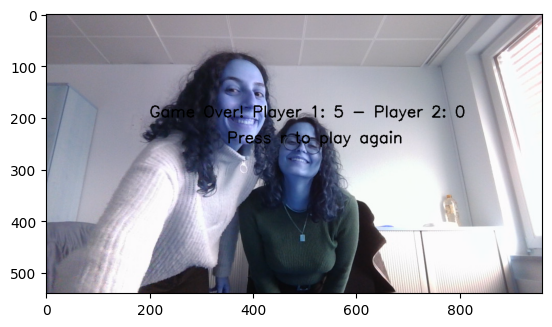

In [14]:
plt.imshow(frame)

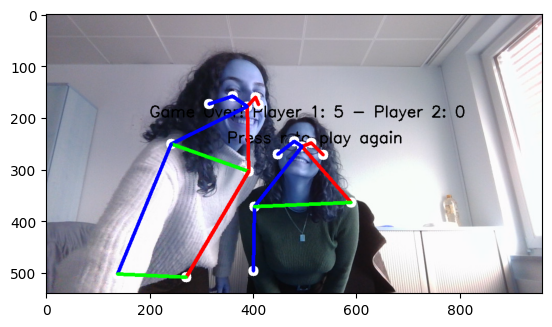

In [15]:
plt.imshow(frame_with_keypoints_and_edges)